# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

**By:**  
Group 8

<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [1]:
!pip install --quiet zipfile36

**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [5]:
random.seed(123)
np.random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [6]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

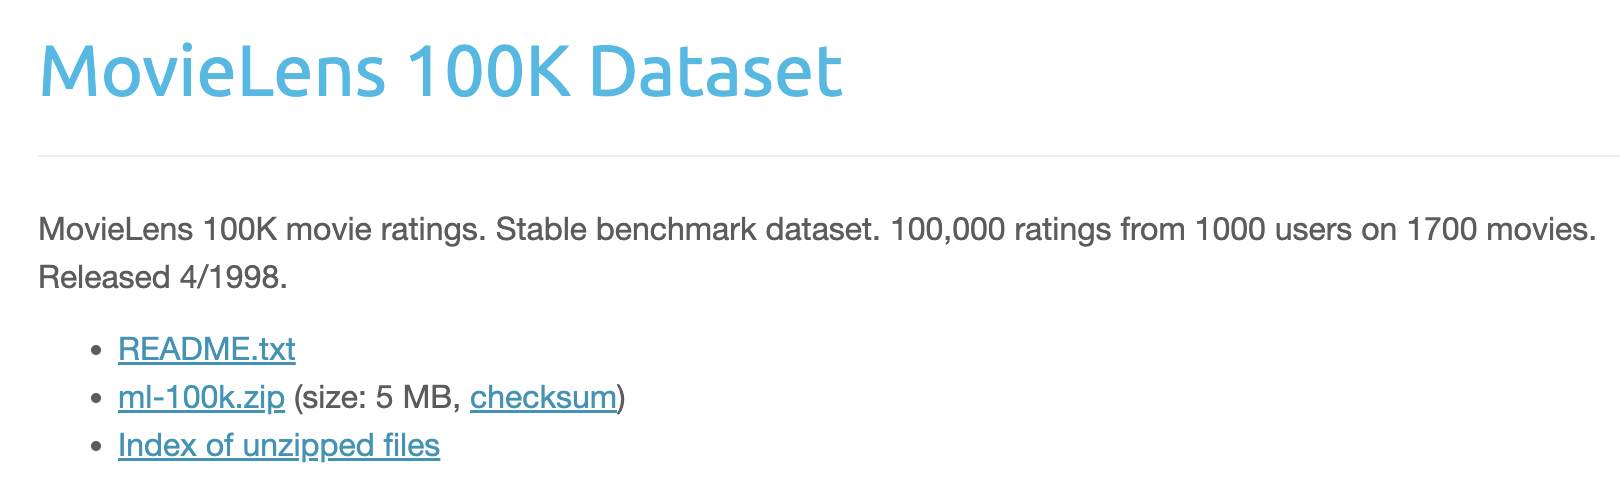

**Columns Names**

In [7]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [8]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [9]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [10]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are mathing the info data file

In [11]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [12]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>

**Explore ratings data:**

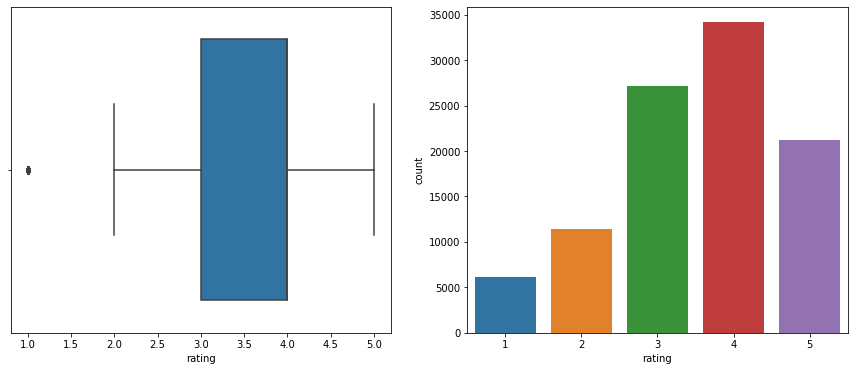

In [13]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

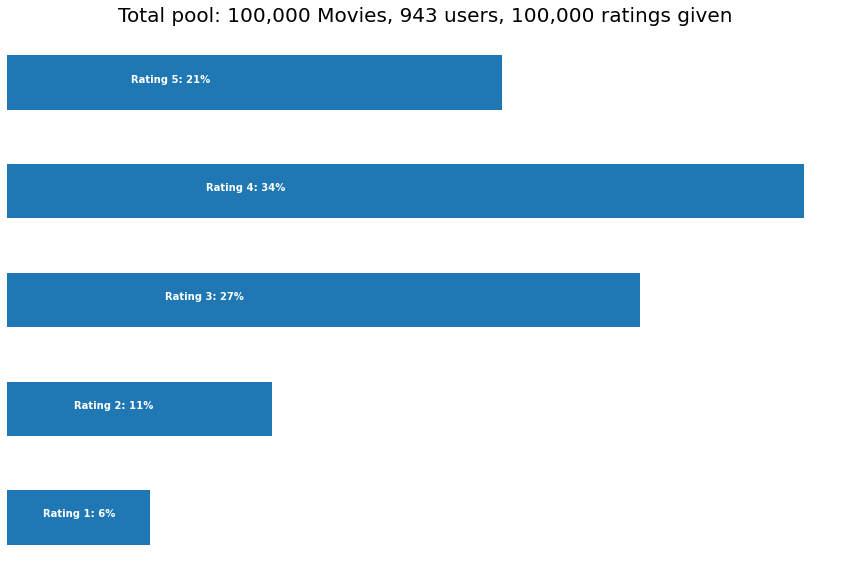

In [14]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.count()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

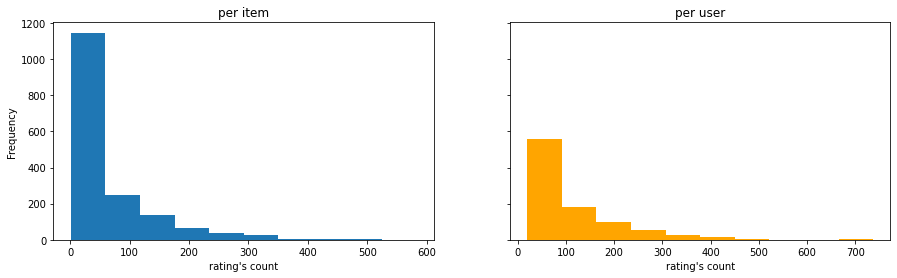

In [15]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

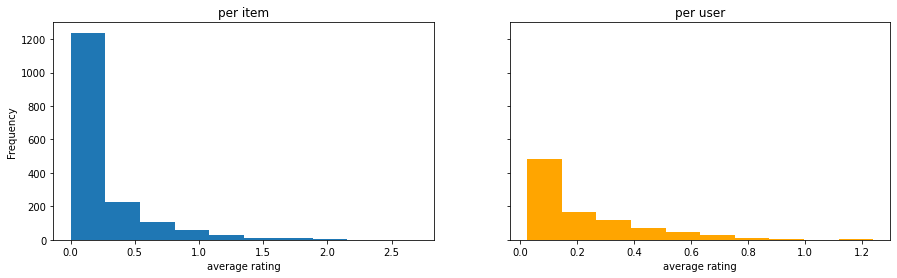

In [16]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

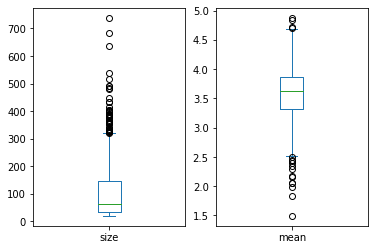

In [17]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

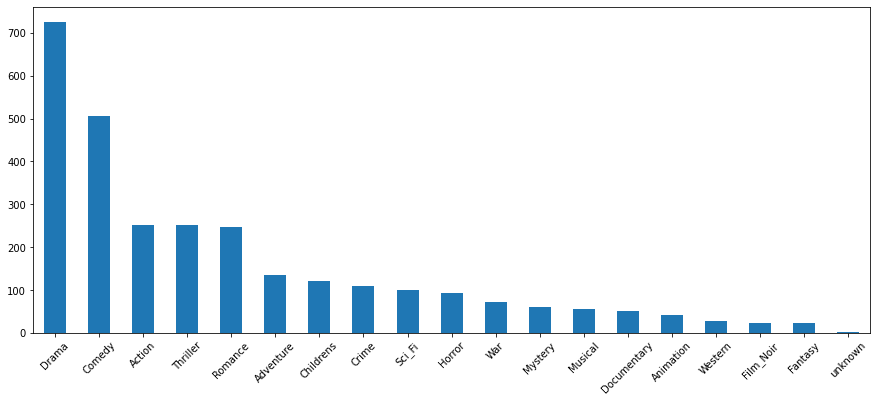

In [18]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [19]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [20]:
class my_metrics():
        
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        # Mask all the zeros with Nan, so we don't count it towards the mean
        df_true = df_true.fillna(0)
        df_true = df_true.mask(df_true == 0)
        df_pred = df_pred.clip(lower_bound, upper_bound)
        rmse = np.mean(((df_pred - df_true) ** 2).stack()) ** .5
        return rmse
    
    
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,threshold=3,top_n=5):
        df_true = df_true.fillna(0)
        df_pred = df_pred.clip(lower_bound, upper_bound)
        concated_df = pd.concat([df_true, df_pred], axis=1)
        users_rr = concated_df.apply(lambda x: my_metrics.MRR_for_user(x[:len(x)//2],
                                                                       x[len(x)//2:],
                                                                       threshold,
                                                                       top_n), axis=1)
        
        mrr = users_rr.mean()
        return mrr

    
    # def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
    def MRR_for_user(user_true,user_pred,threshold=3,top_n=5):
        user_true = user_true[user_true > 0]
        user_pred = user_pred.loc[user_true.index].reset_index(drop=True)

        user_true_relevancy = user_true >= threshold
        user_pred_top_n = user_pred.nlargest(top_n)
        relevancy_top_n = user_true_relevancy.reset_index(drop=True).loc[user_pred_top_n.index]

        # If none of the top n are relevant return reciprocal rank 0
        if relevancy_top_n.sum() == 0 or user_pred_top_n.iloc[0] < threshold:
            return 0
        
        reciprocal_rank = 1 / (np.argmax(relevancy_top_n) + 1)
        return reciprocal_rank

    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use NDCG_for_user
        df_true = df_true.fillna(0)
        df_pred = df_pred.clip(lower_bound, upper_bound)
        concated_df = pd.concat([df_true, df_pred], axis=1)
        users_ndcg = concated_df.apply(lambda x: my_metrics.NDCG_for_user(x[:len(x)//2],
                                                                         x[len(x)//2:],
                                                                         top_n), axis=1)
        ndcg = users_ndcg.mean()
        return ndcg
        

    # def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
    def NDCG_for_user(user_true,user_pred,top_n=5):
        # please use DCG function
        user_true = user_true[user_true > 0]
        user_pred = user_pred.loc[user_true.index]

        top_n_pred = user_pred.nlargest(top_n)
        top_n_true = user_true.loc[top_n_pred.index]
        
        dcg = my_metrics.DCG(top_n_true)
        idcg = my_metrics.DCG(top_n_true.sort_values(ascending=False))
        
        ndcg = dcg / idcg
        return ndcg
    

    # def DCG(rel,n):
    def DCG(rel):
        # please implement the DCG formula
        rel = rel.reset_index(drop=True)
        dcg = (rel / np.log2(rel.index + 2)).sum()
        return dcg
    

    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


In [21]:
## TESTING
def test_RMSE():
  test = pd.DataFrame([1,3,6,4,2])
  predicted = pd.DataFrame([2.6,1.5,3.9,7,4.1])

  result = round(my_metrics.RMSE(test, predicted, upper_bound=10), 3)
  actual = round(2.127439775880859, 3)
  assert(result == actual)

test_RMSE()

Checking your evaltuation metrics and performence:

In [22]:
%time my_metrics.get_error(ratings,ratings)

CPU times: user 8.67 s, sys: 102 ms, total: 8.77 s
Wall time: 9.8 s


{'RMSE': 0.0, 'MRR_5': 1.0, 'MRR_10': 1.0, 'NDCG_5': 1.0, 'NDCG_10': 1.0}

<br><br><br><br>

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [23]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [24]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(1))

train.shape,test.shape

((943, 1682), (943, 1682))

In [25]:
full_df = train + test

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [26]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        self.fit_time = 0


    def weighted_rating(self, votes_count, votes_mean, all_votes_mean):
        return (votes_count / (votes_count + self.min_movie_ratings) * votes_mean) + \
               (self.min_movie_ratings / (self.min_movie_ratings + votes_count) * all_votes_mean)


    def fit(self):
        start_time = time.time()

        # Using generic mean votes for prediction
        # Turn 0's into Nan
        df_train_no_zeros = self.df_train.mask(self.df_train == 0)
        # Pandas mean skips Nan values by default, so we don't count no votes
        votes_mean = df_train_no_zeros.mean()
        votes_count = (self.df_train > 0).sum()
        votes_mean_relevant = votes_mean.mask(votes_count < self.min_movie_ratings, 0)
        
        self.recommended[:] = votes_mean_relevant

        self.fit_time = time.time() - start_time
    

    def fit_weighted_rating(self):
        start_time = time.time()

        # Using weighted rating for prediction
        # Turn 0's into Nan
        df_train_no_zeros = self.df_train.mask(self.df_train == 0)
        # Pandas mean skips Nan values by default, so we don't count no votes
        all_votes_mean = df_train_no_zeros.stack().mean()
        votes_mean = df_train_no_zeros.mean()
        votes_count = (self.df_train > 0).sum()

        self.recommended[:] = self.weighted_rating(votes_count, votes_mean, all_votes_mean)

        self.fit_time = time.time() - start_time


    def predict(self,N=10):
        return self.recommended.iloc[0].nlargest(N).index


    def filter_empty_users(self, test):
        non_empty_users_test = test[test.sum(axis=1) > 0]
        non_empty_users_recommended = self.recommended[test.sum(axis=1) > 0]
        return non_empty_users_test, non_empty_users_recommended


    def get_rmse(self,test):
        # please use my_metrics
        non_empty_users_test, non_empty_users_recommended = self.filter_empty_users(test)
        return my_metrics.RMSE(non_empty_users_test, non_empty_users_recommended)

    
    def get_mrr(self,test,k=10,threshold=3):
        # Please use my_metrics
        non_empty_users_test, non_empty_users_recommended = self.filter_empty_users(test)
        return my_metrics.MRR(non_empty_users_test, non_empty_users_recommended,
                              threshold, top_n=k)
    
    
    def get_ndcg(self,test,k=5):
        # please use my_metrics
        non_empty_users_test, non_empty_users_recommended = self.filter_empty_users(test)
        return my_metrics.NDCG(non_empty_users_test, non_empty_users_recommended,
                               top_n=k)
    
    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()]['movie_title']

Checking your model and performance:

In [27]:
# create popularity model
model_pop = POP(train)

# train model
%timeit model_pop.fit()

# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# train model using weighted rating
%timeit model_pop.fit_weighted_rating()

# record model results
final_results.loc[len(final_results)] = 'Popularity Weighted Rating', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# display
final_results

76.7 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.5 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.070555,1.074955,0.972948,0.973191,0.960896,0.955731
1,Popularity Weighted Rating,0.069778,1.040263,0.971133,0.971444,0.960791,0.955085


### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [28]:
class MF():
    
    def __init__(self,df_train,n_factors=10,only_bias=False):
        self.df_train = df_train
        self.R = df_train.values
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = self.R.shape
        
        # biases
        self.original_bias_global = np.sum(self.R)/np.count_nonzero(self.R)
        self.original_bias_rows   = np.sum(self.R,axis=1)/np.count_nonzero(self.R,axis=1) 
        self.original_bias_cols   = np.sum(self.R,axis=0)/np.count_nonzero(self.R,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            self.U = np.zeros((self.n_rows, self.n_factors))
            self.V = np.zeros((self.n_cols, self.n_factors))
        else:
            self.U = np.random.rand(self.n_rows, self.n_factors)
            self.V = np.random.rand(self.n_cols, self.n_factors)
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = np.random.rand(self.n_rows) # random
        self.bias_cols   = np.random.rand(self.n_cols) # random
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True):
        
        start_time = time.time()

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = None

        # please use the class functions 
        # for example(!) :

        for current_iteration in range(self.n_iterations):

            # None ?
            self.history.append(self.get_rmse(self.df_train))
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration!=0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            
            self.optim_GD()

        self.fit_time = time.time() - start_time  
    
    def converging(self):
        error_diff = self.history[-1] - self.history[-2]
        is_converged = np.abs(error_diff) < self.ϵ
        return is_converged

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        for i, j in zip(self.rows_indices, self.cols_indices):

            error_i_j = self.get_error(i, j)
            
            if not self.only_bias:
                self.U[i] += self.α * ((error_i_j * self.V[j]) - (self.λ * self.U[i]))
                self.V[j] += self.α * ((error_i_j * self.U[i]) - (self.λ * self.V[j]))

            self.bias_rows[i] += self.α * (error_i_j - (self.λ * self.bias_rows[i]))
            self.bias_cols[j] += self.α * (error_i_j - (self.λ * self.bias_cols[j]))      

    def get_error(self, i, j):
        error = 0
        if self.R[i, j] == 0:
            return error
        error = self.R[i, j] - self.predict_entry(i, j)
        return error

    def predict_entry(self, i, j):
        bias = self.bias_global + self.bias_rows[i, np.newaxis] + self.bias_cols[np.newaxis, j]
        pred = np.dot(self.U[i], self.V[j].T) + bias
        return pred

    def predict(self, N=10):
        i = np.arange(self.n_rows)
        j = np.arange(self.n_cols)
        bias = self.bias_global + self.bias_rows[i, np.newaxis] + self.bias_cols[np.newaxis, j]
        pred = np.dot(self.U[i], self.V[j].T) + bias
        return pred

    def filter_empty_users(self, test):
        non_empty_users_test = test[test.sum(axis=1) > 0]
        pred = self.predict()
        non_empty_users_pred = pd.DataFrame(pred, index=self.df_train.index, columns=self.df_train.columns)
        non_empty_users_pred = non_empty_users_pred[test.sum(axis=1) > 0]
        return non_empty_users_test, non_empty_users_pred

    def get_rmse(self,test):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.RMSE(non_empty_users_test, non_empty_users_pred)

    def get_mrr(self,test,k=10,threshold=3):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.MRR(non_empty_users_test, non_empty_users_pred, 
                              top_n=k, threshold=threshold)

    def get_ndcg(self,test,k=5):
        non_empty_users_test, non_empty_users_pred = self.filter_empty_users(test)
        return my_metrics.NDCG(non_empty_users_test, non_empty_users_pred, 
                               top_n=k)

Checking your model and performance:

In [29]:
# create MF model
model_mf = MF(train,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=2,verbose=False,regularization=0.01,convergence=1e-100,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mrr(test,k=5), model_mf.get_mrr(test,k=10), model_mf.get_ndcg(test,k=5), model_mf.get_ndcg(test,k=10)

# display
final_results

CPU times: user 438 ms, sys: 225 ms, total: 663 ms
Wall time: 427 ms


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.070555,1.074955,0.972948,0.973191,0.960896,0.955731
1,Popularity Weighted Rating,0.069778,1.040263,0.971133,0.971444,0.960791,0.955085
2,MF,0.426882,1.828356,0.944081,0.944081,0.941743,0.930260


<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [30]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train,n_factors=lf)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter, convergence=conv, regularization=reg, learning_rate=lr, verbose=False)

                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test) 
                    dic['MRR_5'] = mf.get_mrr(test,k=5) 
                    dic['MRR_10'] = mf.get_mrr(test,k=10) 
                    dic['NDCG_5'] = mf.get_ndcg(test,k=5)
                    dic['NDCG_10'] = mf.get_ndcg(test,k=10)
                
                    # record model history
                    dic['History'] = mf.history # model 
                    
                    # add experiment
                    results = results.append(dic,ignore_index=True)

results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,1.846378,0.939615,0.939615,0.940484,0.929922,"[1.8295946903872229, 1.8295439556320878, 1.829...",4.072810
1,5,20,0.001,0.01,0.00100,1.840958,0.943428,0.943428,0.942770,0.930943,"[1.8291616609155854, 1.829102522884547]",0.392235
2,5,20,0.001,0.10,0.00001,1.839182,0.932898,0.932898,0.939905,0.928560,"[1.8260466649021876, 1.8259523224704326, 1.825...",4.130524
3,5,20,0.001,0.10,0.00100,1.845083,0.938344,0.938344,0.940958,0.929912,"[1.8292831325120154, 1.8292036878955251]",0.538591
4,5,20,0.001,1.00,0.00001,1.838457,0.934604,0.934604,0.941184,0.929610,"[1.832187779331874, 1.8320169743486987, 1.8318...",4.913990
5,5,20,0.001,1.00,0.00100,1.844767,0.938344,0.938707,0.942222,0.929750,"[1.8317908377813499, 1.8316251957690595]",0.378956
6,5,20,0.010,0.01,0.00001,1.821954,0.935330,0.935330,0.941281,0.929148,"[1.8291963731717111, 1.8284494531325692, 1.827...",3.877349
7,5,20,0.010,0.01,0.00100,1.841941,0.931627,0.931627,0.939862,0.928774,"[1.829531361545329, 1.828890191060386]",0.376195
8,5,20,0.010,0.10,0.00001,1.822211,0.932353,0.932353,0.938932,0.927422,"[1.830578677135433, 1.8298443619821176, 1.8289...",3.932254
9,5,20,0.010,0.10,0.00100,1.839522,0.936892,0.936892,0.941234,0.930271,"[1.8274281024837733, 1.8266260773672913]",0.380136


**Training history:**

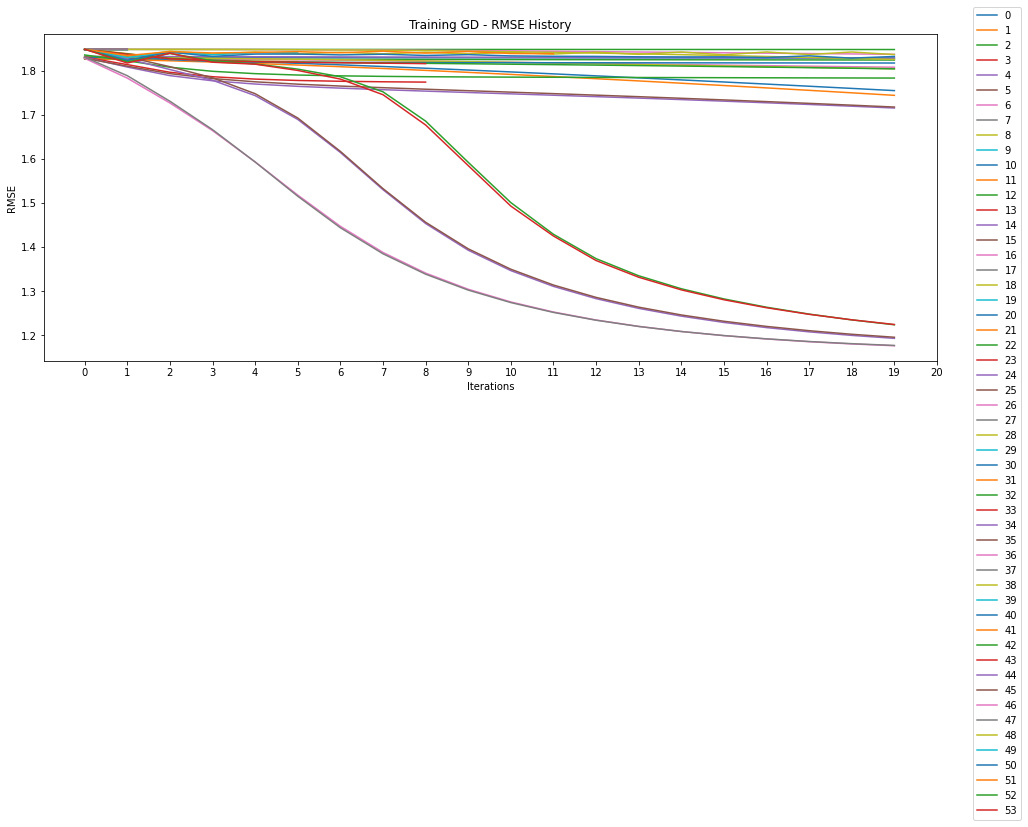

In [31]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [32]:
results.loc[results.RMSE.nsmallest(3).index,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
16,5,20,0.1,1.0,0.00001,1.220145,0.882062,0.882957,0.927617,0.912305,"[1.8279350482854397, 1.7829740469451552, 1.726...",3.962848
17,5,20,0.1,1.0,0.00100,1.223362,0.867792,0.868615,0.922059,0.908637,"[1.8305552599276327, 1.7885043994191605, 1.730...",3.935863
34,10,20,0.1,1.0,0.00001,1.238736,0.883842,0.884788,0.927738,0.911449,"[1.848218942790468, 1.8269945837176496, 1.8024...",3.869756


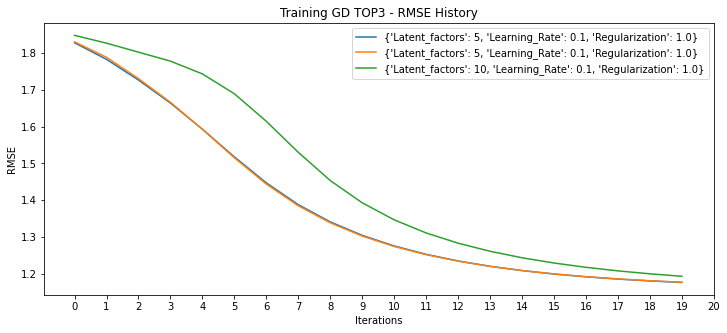

In [33]:
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();


**Q: is there a clear winner?**  

*No, as we can see from the TOP3 RMSE graph, there is no clear winner, and after 20 iterations, the error of these models is very close.*

Please add your winner to `final_results` dataframe.

In [34]:
# final_results = pd.DataFrame(columns=final_results.columns)
best_model = results.loc[results.RMSE.nsmallest(1).index,:]
final_results.loc[len(final_results)] = 'MF Best Model', best_model['Time'].iloc[0], best_model['RMSE'].iloc[0], best_model['MRR_5'].iloc[0], best_model['MRR_10'].iloc[0], best_model['NDCG_5'].iloc[0], best_model['NDCG_10'].iloc[0]
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.070555,1.074955,0.972948,0.973191,0.960896,0.955731
1,Popularity Weighted Rating,0.069778,1.040263,0.971133,0.971444,0.960791,0.955085
2,MF,0.426882,1.828356,0.944081,0.944081,0.941743,0.930260
3,MF Best Model,3.962848,1.220145,0.882062,0.882957,0.927617,0.912305


**Understanding The Effect - `Latent Factors` - Your Conclusions:**

*The larger the latent space, the more complex the model, enabling to learn more features of the data and avoiding underfitting. The training time and the weight of the model will increase accordingly. However, when the latent space is too large, the model becomes too complex, and you may end up overfitting to the train data. Therefore, in general, we want a wide but not too large latent space, especially when the database is smaller.*

*In our case, the model with a latent space of 5  achieved better performance on the test set, than the models with a higher latent space, and indeed the 2 best MF models are using latent space of 5.*


**Understanding The Effect - `Learning Rate` - Your Conclusions:**


*Learning rate represents the rate of convergence, small steps will help us to converge more precisely so we won’t miss the optimum point, but the training require more time, and make it difficult to escape when converging to a local minimum. Where, big steps converge faster, but may lead for overshotting the optimal minima. So, in general, we would like reasonable small steps.*

*A good idea for the future is to implement the model with an adaptive learning rate where at the beginning the steps are larger, and along the convergence the steps decrease. Thus, at the beginning of the journey, the convergence is fast, and enables escape from a local minimum, and along the convergence, the steps are small and allow for more precise progress.*

*In our case, the model with a lr of 0.1  achieved better performance on the test set, than the models with a lower lr, and indeed the 3 best MF models are using lr of 0.1*

**Understanding The Effect - `Regularization` - Your Conclusions:**

*The regularization we’ve implemented prevents the model from giving large weights to certain parameters and thus may help in avoiding overfitting, in which the model predicts well given the train data, but predicts poorly given the test data. However, hard regularization may damage the importance of a significant feature, and in particular a non-quadratic regularization, may lead to a very sparse model. Therefore, in general, we would like to introduce a non-extreme regularization into the model.*

*In our case, the model with a regularization of 1 achieved better performance on the test set, than the models with a lower regularization, and indeed the 3 best MF models are using lr of 1*

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

In [35]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

bias_results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train,n_factors=lf, only_bias=True)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter, convergence=conv, regularization=reg, learning_rate=lr, verbose=False)

                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test) 
                    dic['MRR_5'] = mf.get_mrr(test,k=5) 
                    dic['MRR_10'] = mf.get_mrr(test,k=10) 
                    dic['NDCG_5'] = mf.get_ndcg(test,k=5)
                    dic['NDCG_10'] = mf.get_ndcg(test,k=10)
                
                    # record model history
                    dic['History'] = mf.history # model 
                    
                    # add experiment
                    bias_results = bias_results.append(dic,ignore_index=True)

bias_results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,1.538859,0.930646,0.931009,0.936130,0.924138,"[1.5348427821516106, 1.5347058285337156, 1.534...",3.766100
1,5,20,0.001,0.01,0.00100,1.525391,0.933442,0.933442,0.936029,0.925956,"[1.523694000456399, 1.5235611464184133]",0.363897
2,5,20,0.001,0.10,0.00001,1.551044,0.919572,0.919935,0.932730,0.920846,"[1.5428900953454923, 1.5427037249267748, 1.542...",3.695370
3,5,20,0.001,0.10,0.00100,1.566272,0.924183,0.924494,0.937021,0.925111,"[1.5283917171781876, 1.528209263222518]",0.372727
4,5,20,0.001,1.00,0.00001,1.552691,0.917720,0.917720,0.933874,0.920834,"[1.5306005307010337, 1.5299752257408907, 1.529...",3.697521
5,5,20,0.001,1.00,0.00100,1.527836,0.911728,0.911946,0.933226,0.921915,"[1.5206574965307043, 1.520014716323193]",0.358608
6,5,20,0.010,0.01,0.00001,1.531888,0.923566,0.923929,0.936606,0.924813,"[1.5281921827320746, 1.5267055834965921, 1.525...",3.650132
7,5,20,0.010,0.01,0.00100,1.519515,0.933733,0.934044,0.938371,0.924071,"[1.5142975672641241, 1.5129754482056914, 1.511...",3.034460
8,5,20,0.010,0.10,0.00001,1.532777,0.918192,0.918555,0.932686,0.923530,"[1.5270255353063509, 1.5251838364511499, 1.523...",3.611242
9,5,20,0.010,0.10,0.00100,1.524329,0.920625,0.920625,0.930725,0.919558,"[1.525252459527951, 1.5234934038872723, 1.5217...",3.612557


**Choose your top3 models:**


In [36]:
bias_results.loc[bias_results.RMSE.nsmallest(3).index,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
35,10,20,0.1,1.0,0.00100,1.202546,0.856609,0.857866,0.919115,0.907035,"[1.5277562140961956, 1.4613123024649515, 1.403...",3.622823
17,5,20,0.1,1.0,0.00100,1.203638,0.874873,0.876273,0.923837,0.910325,"[1.5329882655091005, 1.4639553019694957, 1.403...",3.605209
52,20,20,0.1,1.0,0.00001,1.207042,0.858787,0.860499,0.921248,0.906376,"[1.5382512878911763, 1.47103494988833, 1.41147...",3.609888


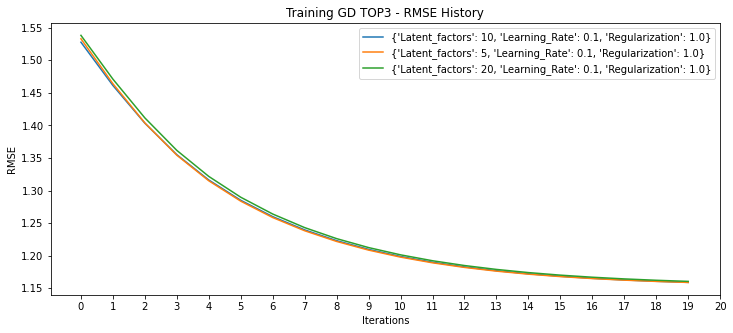

In [37]:
bias_lines = bias_results.History
bias_lines = bias_lines[bias_results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in bias_lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (bias_results.loc[bias_results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();

**Add your winner to `final_resuls` dataframe:**

In [38]:
# final_results = pd.DataFrame(columns=final_results.columns)
best_bias_model = bias_results.loc[bias_results.RMSE.nsmallest(1).index,:]
final_results.loc[len(final_results)] = 'MF Best Bias Only Model', best_bias_model['Time'].iloc[0], best_bias_model['RMSE'].iloc[0], best_bias_model['MRR_5'].iloc[0], best_bias_model['MRR_10'].iloc[0], best_bias_model['NDCG_5'].iloc[0], best_bias_model['NDCG_10'].iloc[0]
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.070555,1.074955,0.972948,0.973191,0.960896,0.955731
1,Popularity Weighted Rating,0.069778,1.040263,0.971133,0.971444,0.960791,0.955085
2,MF,0.426882,1.828356,0.944081,0.944081,0.941743,0.930260
3,MF Best Model,3.962848,1.220145,0.882062,0.882957,0.927617,0.912305
4,MF Best Bias Only Model,3.622823,1.202546,0.856609,0.857866,0.919115,0.907035


<br><br>
**Different Methos - Conclude Final Results**

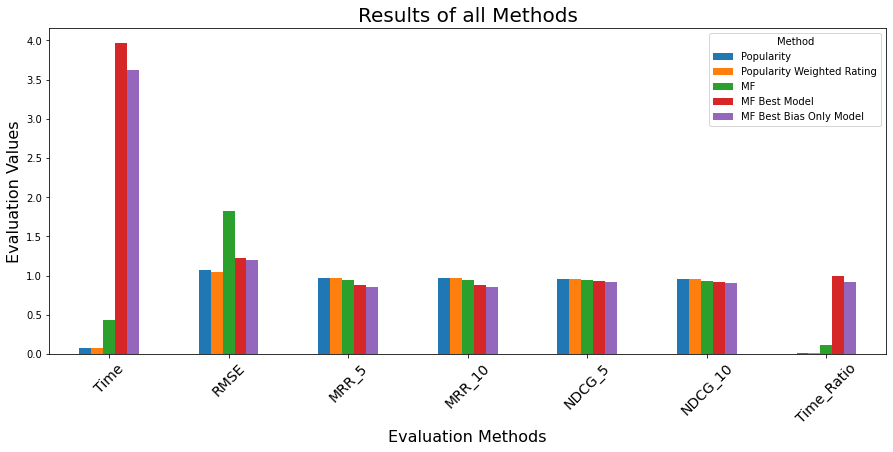

,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Time_Ratio
Method,,,,,,,
Popularity,0.070555,1.074955,0.972948,0.973191,0.960896,0.955731,0.017804
Popularity Weighted Rating,0.069778,1.040263,0.971133,0.971444,0.960791,0.955085,0.017608
MF,0.426882,1.828356,0.944081,0.944081,0.941743,0.930260,0.107721
MF Best Model,3.962848,1.220145,0.882062,0.882957,0.927617,0.912305,1.000000
MF Best Bias Only Model,3.622823,1.202546,0.856609,0.857866,0.919115,0.907035,0.914197


In [39]:
final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time']/final_results['Time'].max()

final_results.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

**Understand `only-Bias-model` VS `full-model` - Your Conclusions:**

*The Only-Bias model is surprisingly good despite its simplicity. As we learned in class, one of the lessons from the Netflix prize challenge was:*

"*Of the numerous new algorithmic contributions, I would like to highlight one - those humble baseline predictors (or biases), which capture main effects in the data. While the literature mostly concentrates on the more sophisticated algorithmic aspects, we have learned that an accurate treatment of main effects is probably at least as significant as coming up with modeling breakthroughs*"

*Thus, based on that, it might not be as surprising as one would initially think.*




<br><br><br><br><br><br><br>

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

`popularity bias:` Please refers to system recommends the movies with the most interactions without any personalization

`item cold-start problem:` Please refers to when movies added to the catalogue have either none or very little interactions while recommender rely on the movie’s interactions to make recommendations

`scalability issue:` Please refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database

<< Your Answer here >>

`Popularity Model`:

*The popularity model check about the movies which are in trend or are most popular among the users and directly recommend those. It is a good pick for a baseline model. It’s a simple and explainable model, computation time is low, the model’s scalability is high, there is no need for the user's historical data, and it does not suffer from cold start. However, this model is not personalized, the system would recommend the same sort of movies which are solely based upon popularity to every other user. Also, it is difficult for a new movie to enter the list of popular movies*

`MF and Bias only`:

*The MF model objective is to factorize a user-item matrix into two low-ranked matrices, the user-factor matrix and the item-factor matrix that can predict new items that users might be interested in. The model knows to handle sparsity and it is able to achieve nice results with no domain knowledge, since the embeddings are naturally learned.*

*The MF model suffers from the cold start problem, since we cannot make predictions for items and users we’ve never encountered in the training data because we don’t have embeddings for them. The cold-start problem can be addressed by including recommending popular items, asking the user to rate some items, or using a content-based approach until we have enough data to use collaborative filtering. Also, It’s hard to get feedback from users. Most users rate things only when they really like something or absolutely hate it. Thus, in future work it will be nice to also measure implicit models.*
 
*Also, the training time is much longer, especially  on scale and after tunning the hyperparameters. Also, as more users and movies are added to the dataset, the sparsity of the matrix increases significantly, and the learning process becomes more complex. Thus, at scale we assume the performance will decrease while the running time will dramatically increase.*

*When referring to the results we received, we can say that both models have achieved nice performance. This was not surprising for the MF model, however, we were surprised of the good results achieved by the bias-only model, despite its simplicity, and it might be a good model to start with after using the popularity model as a baseline.*

*We see that having Latent factor K=5 is enough to capture well the information of the data. For the future, we could investigate more values, higher resolution of K, look into larger datasets and do more hyper parameter search. For MF, learning rate and regularization had to be high, 0.1 and 1.0, otherwise, the steps weren't large enough to reach a good local minima and we would not generalize well enough.*

`General Conclusions`:

*The metrics used for evaluation are all relevant, each having their own unique characteristics. RMSE allows easy interpretation: on the same scale as the original ratings. MRR and NDCG are rank aware evaluation metrics, where MRR is less global than NDCG as it doesn't penalizes on the entire window.*

*Finally, In future work we would like to implement the ALS model, use adaptive learning rate (such as Adam), try both L1 and L2 regularization, try a wider range of hyper-parameters, try using mini batches, and try implementing implicit models.*


`MRR VS nDCG`

**MRR**  
`Pros:`   
    - Simple to compute and easy to interpret  
    - Puts high focus on the first relevant element of the list. Good for targeted searches, as in when users ask for the "best item for me"

`Cons:`    
    - Does not evaluate the rest of the list of recommended items, since it focuses on a single item from the list  
    - Gives the same weight for a list with a single relevant item and a list with many relevant items  

**NDCG**  
`Pros:`  
    - It takes into account the graded relevance values (when available)  
    - Does a good job evaluting the position of ranked items
    - The smooth logarithmic discounting factor has a good theoretical basis, being able to consistently determine the better ranking recommender for every pair that are substantially different   

`Cons:`  
    - Has issues with incomplete ratings, requiring to find ways to impute missing ratings  
    - Need to handle the case when users have no relevant items, IDCG=0
    <br/>
    - Need to handle NDCG@K when the size of the returned ranked list is less than K 

<br><br><br><br>

# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. 


**Find similarity between items and demonstrate the approach on a set of 3 item triplets of your choice based on item representation by your one of your top3 matrix factorization model.**
  
**Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach.**

In [40]:
model = MF(full_df, n_factors=5)
model.fit(n_iterations=20, learning_rate=0.1, regularization=1.0, convergence=0.001, verbose=False)

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


In [41]:
def get_item2vec(mf,i):
    return mf.V[i-1]


def get_pearson_similarity(a,b):
    return np.corrcoef(a, b)


def get_cosine_similarity(a,b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def get_mean_diff_similarity(a1,a2):
    return np.mean(np.abs(a1 - a2))


def get_l2_similarity(a1,a2):
    return np.linalg.norm(a1 - a2)


**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

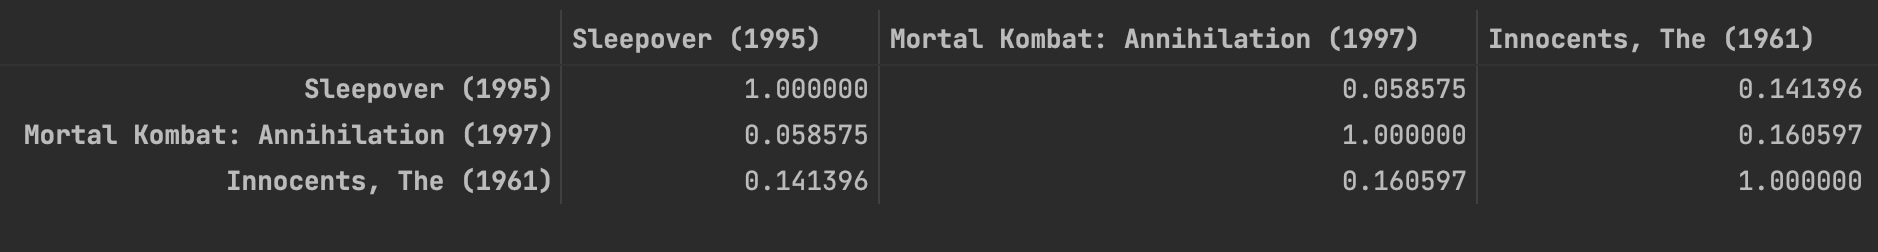

*Let's list the movies to make it easier for us to choose pairs and triplets*

In [42]:
items_length = len(df_items)
list(df_items['movie_title'].sort_values()[:int(items_length/2)])

["'Til There Was You (1997)",
 '1-900 (1994)',
 '101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '187 (1997)',
 '2 Days in the Valley (1996)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 '3 Ninjas: High Noon At Mega Mountain (1998)',
 '39 Steps, The (1935)',
 '8 1/2 (1963)',
 '8 Heads in a Duffel Bag (1997)',
 '8 Seconds (1994)',
 'A Chef in Love (1996)',
 'Above the Rim (1994)',
 'Absolute Power (1997)',
 'Abyss, The (1989)',
 'Ace Ventura: Pet Detective (1994)',
 'Ace Ventura: When Nature Calls (1995)',
 'Across the Sea of Time (1995)',
 'Addams Family Values (1993)',
 'Addicted to Love (1997)',
 'Addiction, The (1995)',
 'Adventures of Pinocchio, The (1996)',
 'Adventures of Priscilla, Queen of the Desert, The (1994)',
 'Adventures of Robin Hood, The (1938)',
 'Affair to Remember, An (1957)',
 'African Queen, The (1951)',
 'Afterglow (1997)',
 'Age of Innocence, The (1993)',
 'Aiqing wansui (1994)',
 'Air Bud (1997)',
 'Air Force One (1997)',
 'Air Up 

In [43]:
items_length = len(df_items)
list(df_items['movie_title'].sort_values()[int(items_length/2):])

['L.A. Confidential (1997)',
 'Lady of Burlesque (1943)',
 'Ladybird Ladybird (1994)',
 'Lamerica (1994)',
 'Land Before Time III: The Time of the Great Giving (1995) (V)',
 'Land and Freedom (Tierra y libertad) (1995)',
 'Larger Than Life (1996)',
 'Lashou shentan (1992)',
 'Lassie (1994)',
 'Last Action Hero (1993)',
 'Last Dance (1996)',
 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)',
 'Last Man Standing (1996)',
 'Last Summer in the Hamptons (1995)',
 'Last Supper, The (1995)',
 'Last Time I Committed Suicide, The (1997)',
 'Last Time I Saw Paris, The (1954)',
 'Last of the Mohicans, The (1992)',
 'Late Bloomers (1996)',
 'Laura (1944)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Lawnmower Man, The (1992)',
 'Lawrence of Arabia (1962)',
 'Lay of the Land, The (1997)',
 'Leading Man, The (1996)',
 'Leave It to Beaver (1997)',
 'Leaving Las Vegas (1995)',
 'Legal Deceit (1997)',
 'Legends of the Fall (1994)',
 'Leopard Son, The (1996)',
 'Letter From Death Ro

In [105]:
def get_triplet_coeff(titles):
  first_triple_df = pd.DataFrame(columns = titles, index = titles)
  for i,r in enumerate(titles):
    for j,c in enumerate(titles):
      first_triple_df.iloc[i,j] = get_pearson_similarity(get_item2vec(model, int(df_items.loc[df_items['movie_title'] == r]['movie id'])),
                                                get_item2vec(model, int(df_items.loc[df_items['movie_title'] == c]['movie id'])))[0,1]
  return first_triple_df

**5 Pairs: (as requested in 4.a.)**

In [106]:
titles = ['Alice in Wonderland (1951)',
'Aladdin and the King of Thieves (1996)']
first_pair_df = get_triplet_coeff(titles)
first_pair_df

,Alice in Wonderland (1951),Aladdin and the King of Thieves (1996)
Alice in Wonderland (1951),1.0,0.616303
Aladdin and the King of Thieves (1996),0.616303,1.0


In [107]:
titles = ['Jaws 2 (1978)',
          'Jaws 3-D (1983)']
second_pair_df = get_triplet_coeff(titles)
second_pair_df

,Jaws 2 (1978),Jaws 3-D (1983)
Jaws 2 (1978),1.0,0.860494
Jaws 3-D (1983),0.860494,1.0


In [108]:
titles = ['Candyman (1992)',
          'Candyman: Farewell to the Flesh (1995)']
third_pair_df = get_triplet_coeff(titles)
third_pair_df

,Candyman (1992),Candyman: Farewell to the Flesh (1995)
Candyman (1992),1.0,0.625363
Candyman: Farewell to the Flesh (1995),0.625363,1.0


In [109]:
titles = ['Die Hard (1988)',
          'Die Hard: With a Vengeance (1995)',]
fourth_pair_df = get_triplet_coeff(titles)
fourth_pair_df

,Die Hard (1988),Die Hard: With a Vengeance (1995)
Die Hard (1988),1.0,0.658266
Die Hard: With a Vengeance (1995),0.658266,1.0


In [110]:
titles = ['Batman (1989)',
          'Batman Forever (1995)']
fifth_pair_df = get_triplet_coeff(titles)
fifth_pair_df

,Batman (1989),Batman Forever (1995)
Batman (1989),1.0,0.440746
Batman Forever (1995),0.440746,1.0


*We can definatly see some logic behind the embedding which suggest that pearson similarity of the embeddings can be a good candidate for finding similarities between items, and we gonna use this method for comparing triplets*

**First Triplet:**

In [45]:
titles = ["Amityville 1992: It's About Time (1992)",
          'Amityville II: The Possession (1982)',
          'Amityville: A New Generation (1993)']

In [46]:
first_triple_df = get_triplet_coeff(titles)
first_triple_df

,Amityville 1992: It's About Time (1992),Amityville II: The Possession (1982),Amityville: A New Generation (1993)
Amityville 1992: It's About Time (1992),1.0,0.588654,0.866218
Amityville II: The Possession (1982),0.588654,1.0,0.455201
Amityville: A New Generation (1993),0.866218,0.455201,1.0


In the first triplet we've used a series of the same movies, as expected there is a positive correlation between the triplet

**Second Triplet:**

In [84]:
titles = ['Cinderella (1950)',
          'Alice in Wonderland (1951)',
          'Mortal Kombat: Annihilation (1997)']

In [85]:
second_triple_df = get_triplet_coeff(titles)
second_triple_df

,Cinderella (1950),Alice in Wonderland (1951),Mortal Kombat: Annihilation (1997)
Cinderella (1950),1.0,0.129159,-0.822922
Alice in Wonderland (1951),0.129159,1.0,-0.170282
Mortal Kombat: Annihilation (1997),-0.822922,-0.170282,1.0


In the second triplet we've taken a triplets with some contrast. As expected, there is a negative correlation between the opposed movies

**Third Triplet**

In [90]:
titles = ['Star Trek: The Motion Picture (1979)',
          'Star Trek III: The Search for Spock (1984)', 
          'Star Trek: The Wrath of Khan (1982)']

In [91]:
third_triple_df = get_triplet_coeff(titles)
third_triple_df

,Star Trek: The Motion Picture (1979),Star Trek III: The Search for Spock (1984),Star Trek: The Wrath of Khan (1982)
Star Trek: The Motion Picture (1979),1.0,-0.069786,-0.960798
Star Trek III: The Search for Spock (1984),-0.069786,1.0,-0.209318
Star Trek: The Wrath of Khan (1982),-0.960798,-0.209318,1.0


Finally, In the third triplet we've used another series of the same movies, but unfortunately, we found no / negative correlation between the triplets, which can suggest the model's item embeddings sometimes does not capture some insights

<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




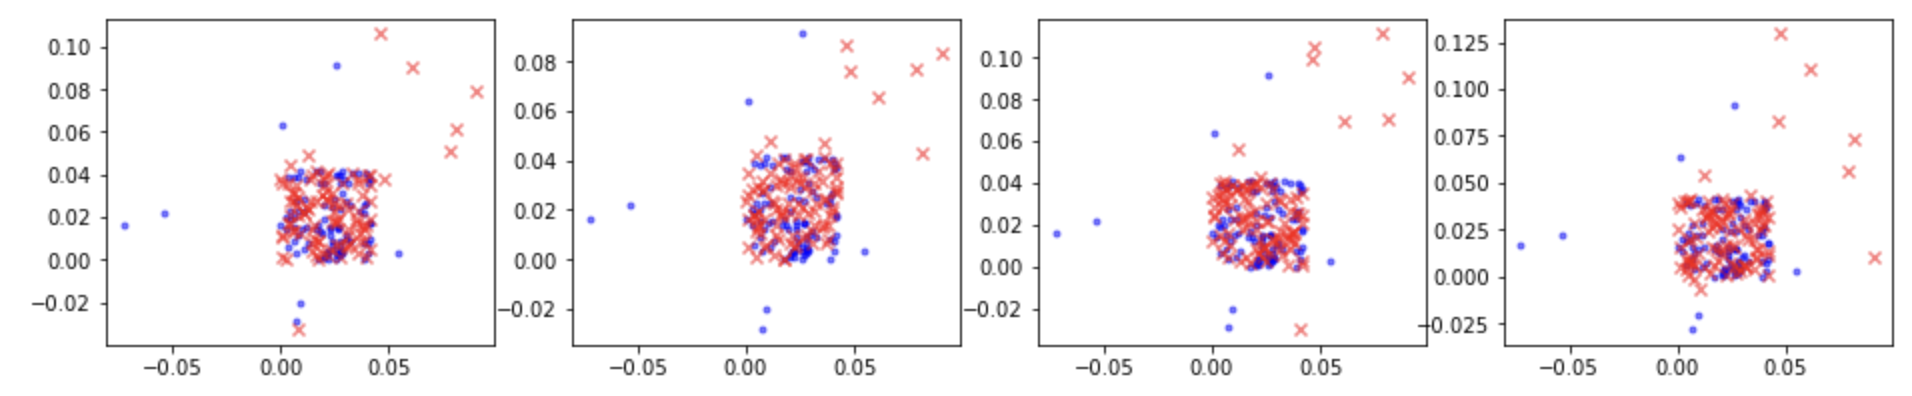

### Comparison between the different Latent dimensions

In [51]:
def plot_two_latent(model, genre_a, genre_b, latent_v, n_latent):
    fig, ax = plt.subplots(1,4,figsize=(16,4), constrained_layout=True)
    j = 0
    for i in n_latent:
        v_a = model.V[genre_a - 1][:,[latent_v,i]]
        v_b = model.V[genre_b - 1][:,[latent_v,i]]
        ax[j].set_title(f'Vector {latent_v+1} VS Vector {i+1}')
        ax[j].scatter(v_a[:,0], v_a[:,1], marker='.', color='blue', alpha=0.5)
        ax[j].scatter(v_b[:,0], v_b[:,1], marker='x', color='red', alpha=0.3)
        j += 1

    fig.suptitle(f'Latent Vector {latent_v} Comparison', fontsize=16)
    plt.show()

#### Romance Vs Horror

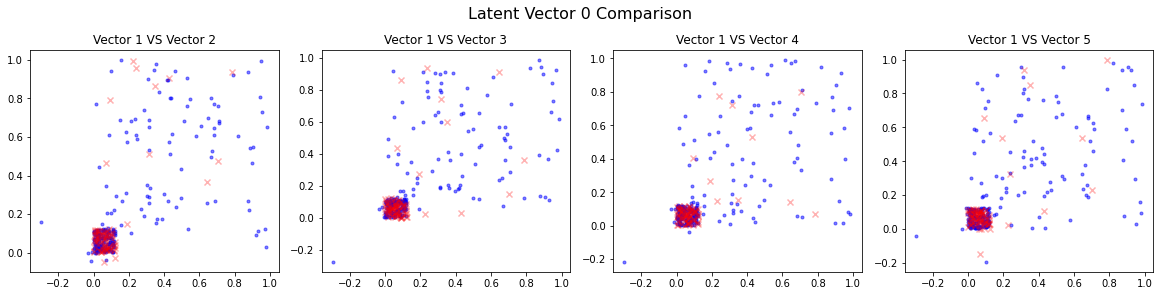

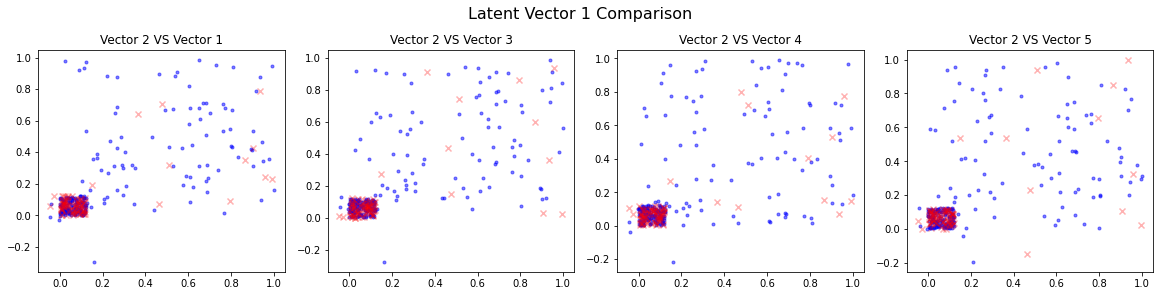

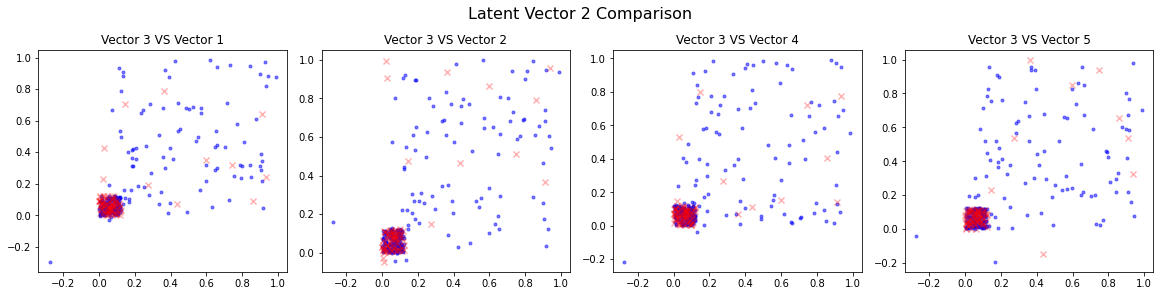

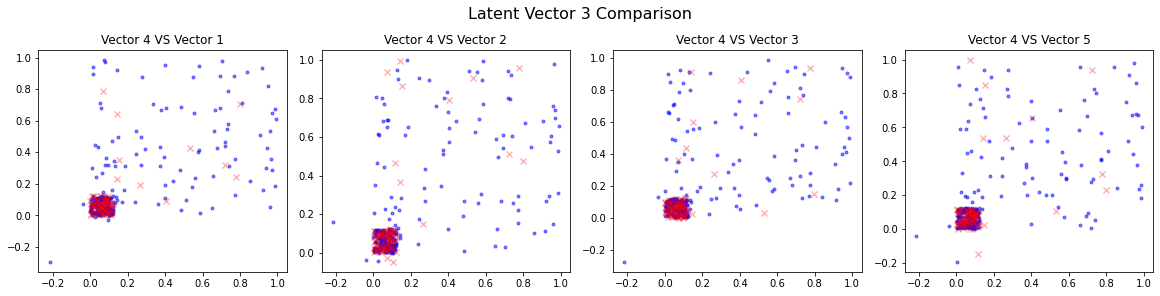

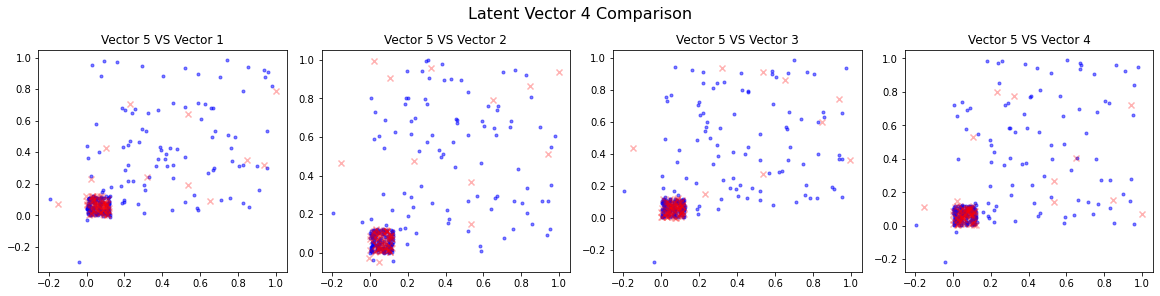

In [52]:
for i in np.arange(5):
    latents = np.arange(5)
    latents = latents[latents != i]
    romance = df_items[df_items.Romance == 1]['movie id']
    horror =  df_items[df_items.Horror == 1]['movie id']
    plot_two_latent(model, romance, horror, i, latents)

#### Musical Vs Documentary

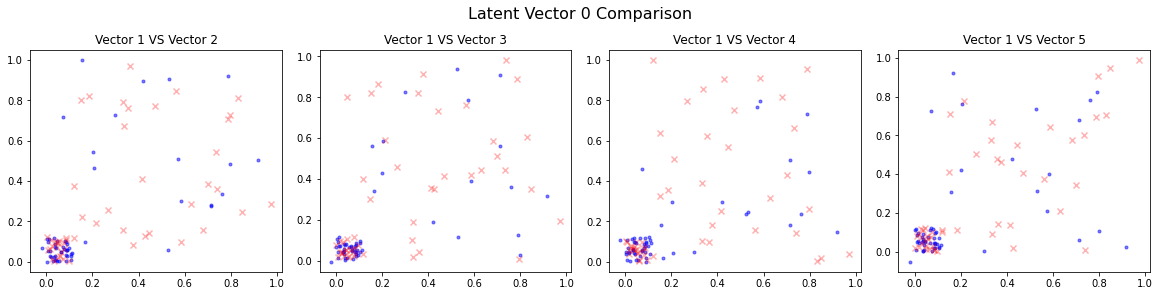

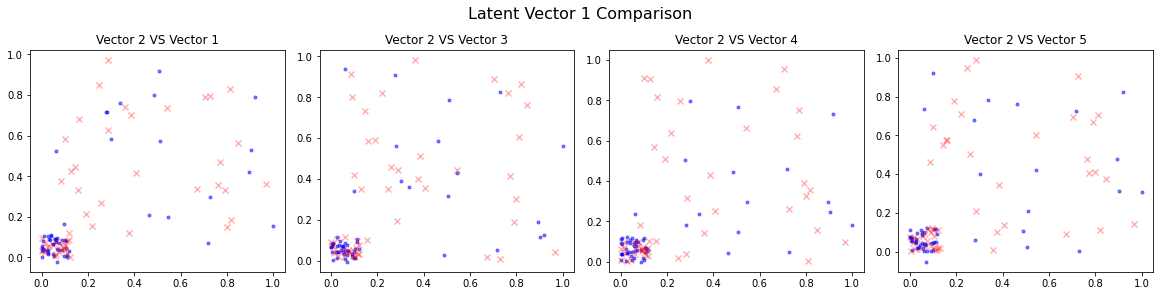

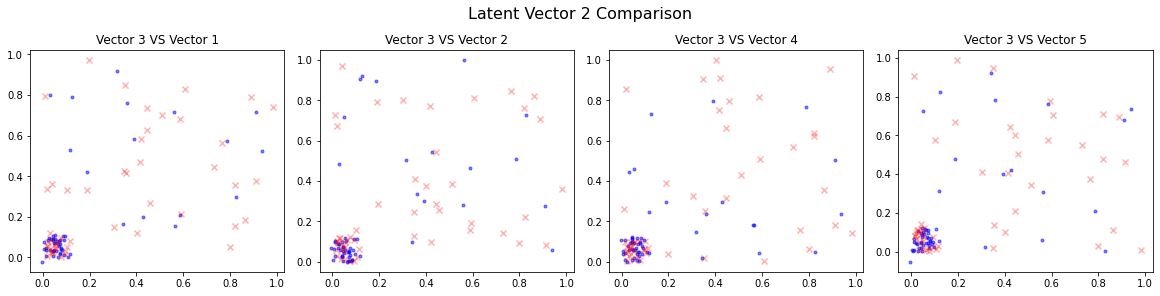

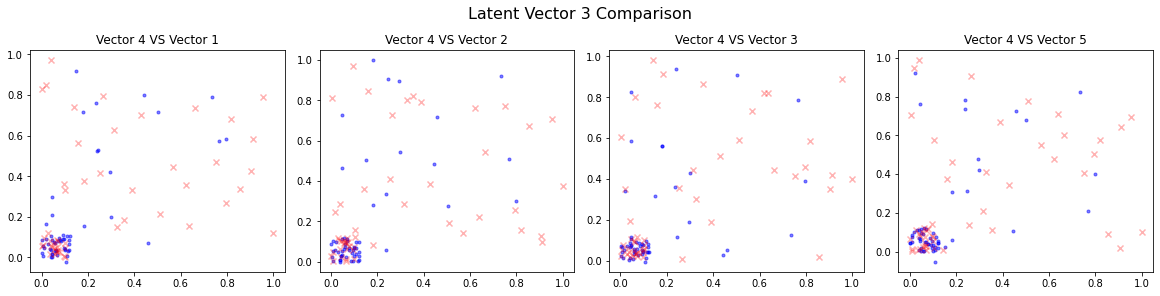

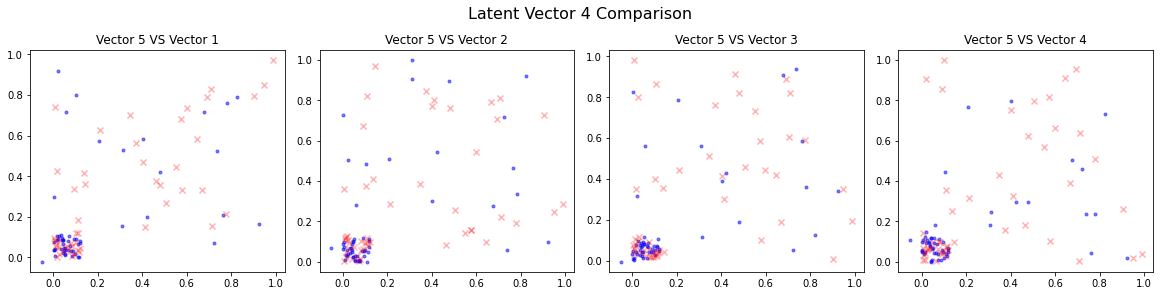

In [53]:
for i in np.arange(5):
    latents = np.arange(5)
    latents = latents[latents != i]
    musical = df_items[df_items.Musical == 1]['movie id']
    documentary =  df_items[df_items.Documentary == 1]['movie id']
    plot_two_latent(model, musical, documentary, i, latents)

When looking at and comparing all the different Latent Dimensions of different Genres we still don't see any good seperation

### Dimension Reduction using TSNE

We try to see if there's a clear seperation for Movies with only 1 genre using TSNE to reduce the Latent Dimension to 2

In [54]:
model.V.shape

(1682, 5)

In [55]:
classes = ['Action','Adventure','Animation', 'Childrens','Comedy','Crime',
          'Documentary','Drama', 'Fantasy','Film_Noir','Horror','Musical',
          'Mystery','Romance', 'Sci_Fi','Thriller','War','Western']

In [56]:
df_items[classes].sum(axis=1)

0       3
1       3
2       1
3       3
4       3
       ..
1677    1
1678    2
1679    2
1680    1
1681    1
Length: 1682, dtype: int64

In [57]:
df_single_genre = df_items.loc[df_items[classes].sum(axis=1) == 1]
df_single_genre[classes].sum(axis=1)

2       1
5       1
8       1
12      1
14      1
       ..
1675    1
1676    1
1677    1
1680    1
1681    1
Length: 831, dtype: int64

In [58]:
df_genre = pd.DataFrame()
df_genre['Genre'] = df_single_genre[classes].idxmax(axis=1)
labels = list(df_genre['Genre'])

In [59]:
single_genre_indexes = df_single_genre.index.values.tolist()
single_genre_indexes = [x-1 for x in single_genre_indexes]
single_genre_ratings = train.iloc[:, single_genre_indexes]
single_genre_ratings

item_id,2,5,8,12,14,17,18,24,25,26,...,1667,1670,1671,1673,1674,1675,1676,1677,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,1.0,0.0,0.0,0.0,4.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,5.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(831, 2)


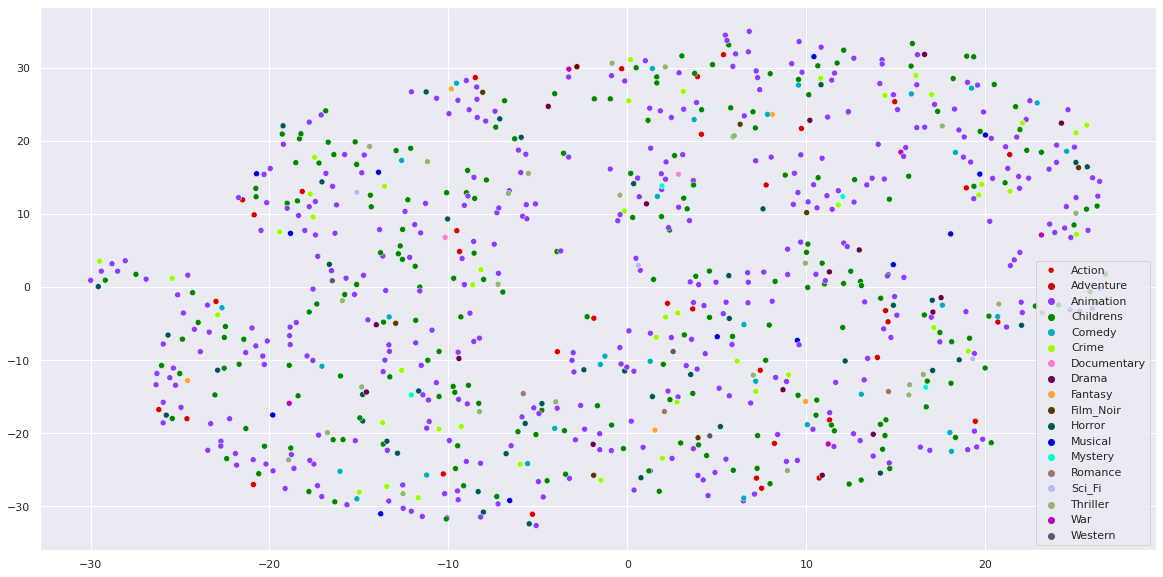

In [60]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import colorcet as cc

model_single_genre = MF(single_genre_ratings, n_factors=5)
model_single_genre.fit(n_iterations=20, learning_rate=0.1, regularization=0.1, convergence=0.001, verbose=False)

tsne_result = TSNE(n_components=2, learning_rate=50, init='random').fit_transform(model_single_genre.V)
print(tsne_result.shape)

sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette(cc.glasbey, 18)
sns.scatterplot(tsne_result[:,0], tsne_result[:,1], hue=labels, legend='full', palette=palette)
plt.legend(labels=classes)

*We've reduced the matrix to only observations in which there is a single genre. Then, using TSNE, we've downgrade the embedding latent dimenstions to two dimenstions so that we can create a visualization out of it. we've used all genres in our plot's legend, where each movie on the graph is marked with the corresponding genre from the legend.*

*Unfourtantly, as we can see, we couldn't find a good seperation between any of the genres.*

*In a future work it might be a good idea to try and find a good seperation between the release dates (instead of the genres) by setting a threshold, or to further investigate the user embeddings and see if we may find any good seperation based on the user's age, genders or occupations.*